In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [24]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, timedelta
import matplotlib.dates as mdates #makes graphs look better

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflect the tables
Base.prepare(engine, reflect=True)

# Now you can access the classes for the tables
Station = Base.classes.station
Measurement = Base.classes.measurement

C:\Users\jt4ha\AppData\Local\Temp\ipykernel_32516\1466765084.py:2: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
for class_name in Base.classes.keys():
    print(class_name)

measurement
station


In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


0      2016-08-24
1      2016-08-24
2      2016-08-24
3      2016-08-24
4      2016-08-24
          ...    
2218   2017-08-22
2221   2017-08-23
2219   2017-08-23
2220   2017-08-23
2222   2017-08-23
Name: Date, Length: 2223, dtype: datetime64[ns]


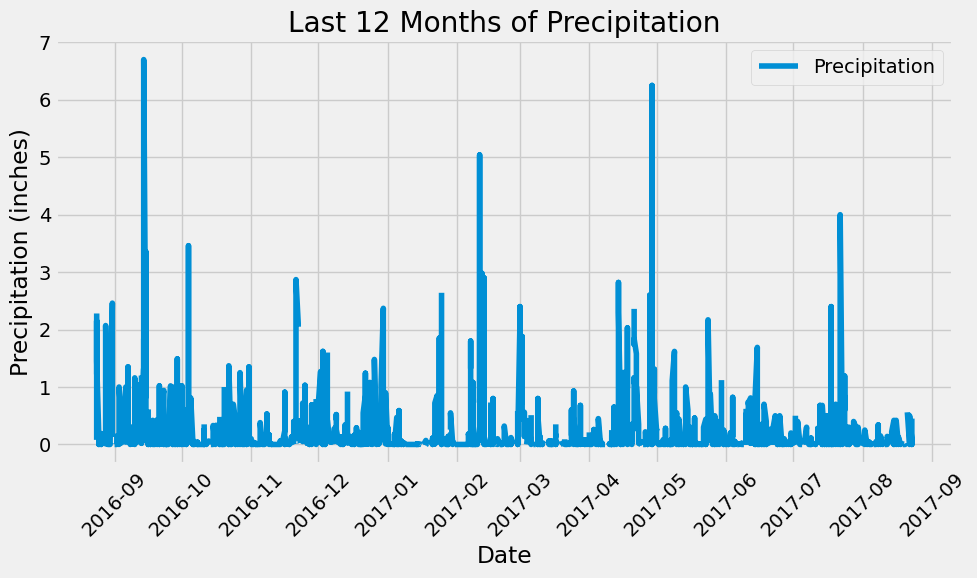

In [29]:

most_recent_date_str = most_recent_date[0]
most_recent_date_dt = datetime.strptime(most_recent_date_str, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date_dt - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Convert the 'Date' column to datetime format
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')
print(precipitation_df['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['Precipitation'].describe()
count = precipitation_summary['count']
mean = precipitation_summary['mean']
std = precipitation_summary['std']
percentile_25 = precipitation_summary['25%']
median = precipitation_summary['50%']
percentile_75 = precipitation_summary['75%']
max_value = precipitation_summary['max']
print(f"Count: {count}")
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")
print(f"25th Percentile: {percentile_25}")
print(f"50th Percentile (Median): {median}")
print(f"75th Percentile: {percentile_75}")
print(f"Max: {max_value}")


Count: 2015.0
Mean: 0.17646153846153845
Standard Deviation: 0.4602883636813257
25th Percentile: 0.0
50th Percentile (Median): 0.02
75th Percentile: 0.13
Max: 6.7


# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [34]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

# Print the result in the format [(low, high, average)]
print(temperature_stats)

[(54.0, 85.0, 71.66378066378067)]


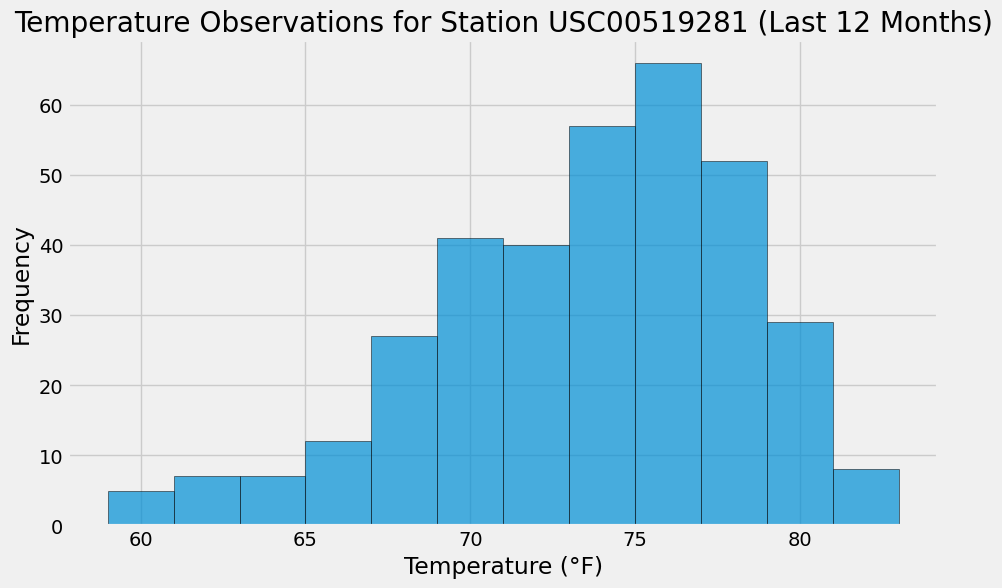

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    all()
temperatures = [temp[0] for temp in temperature_data]
plt.figure(figsize=(10,6))
plt.hist(temperatures, bins=12, edgecolor='black', alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)')
plt.show()

# Close Session

In [37]:
# Close Session
session.close()